<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/Metrics_complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
import json
import matplotlib.pyplot as plt
import networkx as nx
import timeit
from tqdm import tqdm

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim


def graph_from_df(df):
  # Build graph to calculate degree of centrality:

  df['login'] = df['login'].apply(lambda x: 'User: '+x)
  df['name'] = df['name'].apply(lambda x: 'Repo: '+x)

  # Build the adjacency matrix
  am = pd.crosstab(df['login'], df['name']).astype(float)
  idx = am.columns.union(am.index)
  am = am.reindex(index = idx, columns=idx, fill_value=0.0)

  matrix_elements = np.sort(df['login'].unique(), axis=0)
  repo_len = len(df['name'].unique())

  #Initialise an auxiliar matrix to record the user - user similarities
  shape = (len(matrix_elements), len(matrix_elements))
  aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

  for i in matrix_elements:
      for j in matrix_elements:

          # Compare row vectors
          aux_vector_a = am.loc[i].to_numpy()[:repo_len]
          aux_vector_b = am.loc[j].to_numpy()[:repo_len]
          
          score = cosine_similarity(aux_vector_a, aux_vector_b)
          aux_matrix.at[i, j] = score

  # Fill adj_matrix with aux_matrix data
  for column in aux_matrix.columns:
      for row in aux_matrix.index:

          aux = aux_matrix.at[row, column]
          am.at[row, column] = aux

  # Build graph from matrix, after user-user connections
  G = nx.from_pandas_adjacency(am)

  return G

def centrality_measures_to_df(data, centrality_name):
    df = pd.DataFrame(data, columns=['Node', centrality_name])
    return df

def raw_centrality_timings(G):

  start_time = timeit.default_timer()
  nx.degree_centrality(G)
  dc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.closeness_centrality(G)
  cc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.betweenness_centrality(G)
  bc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.betweenness_centrality(G, k=int(G.number_of_nodes()*0.2))
  ab_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.eigenvector_centrality(G, tol=1e-04) # add max_iter The default value is 100 cycles.
  ec_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.pagerank(G)
  pr_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.hits(G,max_iter=120)
  ha_time = timeit.default_timer() - start_time

  return [dc_time, cc_time, bc_time, ab_time, ec_time, pr_time, ha_time]

def to_df_centrality_timings(G):

  start_time = timeit.default_timer()
  centrality_measures_to_df(nx.degree_centrality(G).items(), 'Degree_centrality')
  dc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(nx.closeness_centrality(G).items(), 'Closeness_centrality')
  cc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(nx.betweenness_centrality(G).items(), 'Betweenness_centrality')
  bc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(nx.betweenness_centrality(G, k=int(G.number_of_nodes()*0.2)).items(), 'Approximate Betweenness_centrality')
  ab_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(nx.eigenvector_centrality(G, tol=1e-04).items(), 'Eigenvector_centrality') # add max_iter The default value is 100 cycles.
  ec_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(nx.pagerank(G).items(), 'Pagerank')
  pr_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  hub, auth = nx.hits(G,max_iter=120)
  centrality_measures_to_df(hub.items(), 'Hubs')
  centrality_measures_to_df(auth.items(), 'Authorities')
  ha_time = timeit.default_timer() - start_time

  return [dc_time, cc_time, bc_time, ab_time, ec_time, pr_time, ha_time]

In [ ]:
Cobol_df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv')
Cobol_df

,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files
0,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:38:18 UTC,"{""action"":""closed"",""number"":3,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
1,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:28:12 UTC,"{""action"":""opened"",""number"":3,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
2,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 16:19:54 UTC,"{""action"":""closed"",""number"":4,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
3,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:37:56 UTC,"{""action"":""opened"",""number"":4,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
4,PullRequestEvent,mavimaec,vimaec/g3d,2021-11-19 20:40:52 UTC,"{""action"":""closed"",""number"":8,""pull_request"":{...","""COBOL""","""closed""","""mavimaec""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/8""",2,113,702,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-05-14 03:43:29 UTC,"{""action"":""closed"",""number"":115,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,688,1,39
1329,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-06 17:56:00 UTC,"{""action"":""closed"",""number"":127,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1330,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-11-30 22:12:33 UTC,"{""action"":""opened"",""number"":127,""pull_request""...","""COBOL""","""opened""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1331,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-09 04:01:35 UTC,"{""action"":""closed"",""number"":128,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,5,1,1


In [ ]:
input_size = []
number_of_nodes = []
number_of_edges = []
build_graph_timing = []

In [ ]:
# Cobol dataset timmings
input_size.append(Cobol_df.shape[0])

start_time = timeit.default_timer()
Cobol_G = graph_from_df(Cobol_df)
build_graph_timing.append(timeit.default_timer() - start_time)

number_of_nodes.append(Cobol_G.number_of_nodes())
number_of_edges.append(Cobol_G.number_of_edges())

print(nx.info(Cobol_G))
cobol_raw_timings = raw_centrality_timings(Cobol_G)
cobol_to_df_timings = to_df_centrality_timings(Cobol_G)

Graph with 262 nodes and 664 edges


In [ ]:
Pascal_df = pd.read_csv('/content/drive/MyDrive/Socialz/pascal_pullrequests.csv')
Pascal_df

,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files,merged,comments,review_comments
0,PullRequestEvent,User756675678,User756675678/HeidiSQL,2021-02-04 13:04:34 UTC,"{""action"":""opened"",""number"":10,""pull_request"":...","""Pascal""","""opened""","""User756675678""","""User""","""https://api.github.com/repos/User756675678/He...",2,27,10,2,False,0,0
1,PullRequestEvent,hkollmann,TurboPack/Orpheus,2021-12-03 13:35:09 UTC,"{""action"":""opened"",""number"":30,""pull_request"":...","""Pascal""","""opened""","""hkollmann""","""User""","""https://api.github.com/repos/TurboPack/Orpheu...",4,213,67,9,False,0,0
2,PullRequestEvent,tebe6502,tebe6502/Mad-Pascal,2021-02-09 15:29:29 UTC,"{""action"":""closed"",""number"":19,""pull_request"":...","""Pascal""","""closed""","""zbyti""","""User""","""https://api.github.com/repos/tebe6502/Mad-Pas...",1,2,2,1,True,0,0
3,PullRequestEvent,hdxrie,royqh1979/Dev-CPP,2021-02-26 02:51:21 UTC,"{""action"":""opened"",""number"":154,""pull_request""...","""Pascal""","""opened""","""hdxrie""","""User""","""https://api.github.com/repos/royqh1979/Dev-CP...",1,0,0,92,False,0,0
4,PullRequestEvent,rpottsoh,exercism/delphi,2021-10-04 16:36:15 UTC,"{""action"":""closed"",""number"":471,""pull_request""...","""Pascal""","""closed""","""exercism-bot""","""User""","""https://api.github.com/repos/exercism/delphi/...",1,5,0,1,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16442,PullRequestEvent,salvadorbs,salvadorbs/Asuite,2021-08-07 16:09:38 UTC,"{""action"":""closed"",""number"":115,""pull_request""...","""Pascal""","""closed""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/salvadorbs/Asuit...",1,83,15,1,True,0,0
16443,PullRequestEvent,pyscripter,pyscripter/pyscripter,2021-01-19 15:09:17 UTC,"{""action"":""closed"",""number"":1054,""pull_request...","""Pascal""","""closed""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/pyscripter/pyscr...",1,5,1,1,True,0,0
16444,PullRequestEvent,pyscripter,pyscripter/pyscripter,2021-01-19 15:10:00 UTC,"{""action"":""closed"",""number"":1057,""pull_request...","""Pascal""","""closed""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/pyscripter/pyscr...",1,88,0,1,False,1,0
16445,PullRequestEvent,transifex-integration[bot],pyscripter/pyscripter,2021-01-19 15:24:59 UTC,"{""action"":""opened"",""number"":1083,""pull_request...","""Pascal""","""opened""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/pyscripter/pyscr...",1,0,0,0,False,0,0


In [ ]:
# Pascal dataset timmings
input_size.append(Pascal_df.shape[0])

start_time = timeit.default_timer()
Pascal_G = graph_from_df(Pascal_df)
build_graph_timing.append(timeit.default_timer() - start_time)

number_of_nodes.append(Pascal_G.number_of_nodes())
number_of_edges.append(Pascal_G.number_of_edges())

print(nx.info(Pascal_G))
pascal_raw_timings = raw_centrality_timings(Pascal_G)
pascal_to_df_timings = to_df_centrality_timings(Pascal_G)

Graph with 2652 nodes and 6030 edges


In [ ]:
Fortran_df = pd.read_csv('/content/drive/MyDrive/Socialz/fortran_pullrequests.csv')
Fortran_df

,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files,merged,comments,review_comments
0,PullRequestEvent,rpeacoc,firemodels/cfast,2021-02-26 20:01:30 UTC,"{""action"":""closed"",""number"":1790,""pull_request...","""Fortran""","""closed""","""rpeacoc""","""User""","""https://api.github.com/repos/firemodels/cfast...",1,3,1,1,True,0,0
1,PullRequestEvent,jedwards4b,ihesp/cime,2021-04-14 14:04:33 UTC,"{""action"":""closed"",""number"":1,""pull_request"":{...","""Fortran""","""closed""","""jedwards4b""","""User""","""https://api.github.com/repos/ihesp/cime/pulls/1""",1,32,16,3,True,0,0
2,PullRequestEvent,kazulagi,kazulagi/plantFEM,2021-05-02 02:24:04 UTC,"{""action"":""opened"",""number"":164,""pull_request""...","""Fortran""","""opened""","""kazulagi""","""User""","""https://api.github.com/repos/kazulagi/plantFE...",1,987,4,7,False,0,0
3,PullRequestEvent,GeorgeGayno-NOAA,NOAA-EMC/UFS_UTILS,2021-05-03 18:18:47 UTC,"{""action"":""opened"",""number"":493,""pull_request""...","""Fortran""","""opened""","""GeorgeGayno-NOAA""","""User""","""https://api.github.com/repos/NOAA-EMC/UFS_UTI...",7,43,3,3,False,0,0
4,PullRequestEvent,jm-c,MITgcm/MITgcm,2021-06-08 16:01:04 UTC,"{""action"":""closed"",""number"":346,""pull_request""...","""Fortran""","""closed""","""mjlosch""","""User""","""https://api.github.com/repos/MITgcm/MITgcm/pu...",33,2233,1773,7,True,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34379,PullRequestEvent,pull[bot],MRE-Code-Hub/WW3,2021-08-21 00:32:28 UTC,"{""action"":""closed"",""number"":41,""pull_request"":...","""Fortran""","""closed""","""pull[bot]""","""Bot""","""https://api.github.com/repos/MRE-Code-Hub/WW3...",1,24,3550,26,True,0,0
34380,PullRequestEvent,awvwgk,fortran-lang/fpm,2021-09-08 10:56:05 UTC,"{""action"":""closed"",""number"":557,""pull_request""...","""Fortran""","""closed""","""awvwgk""","""User""","""https://api.github.com/repos/fortran-lang/fpm...",1,2,1,1,True,3,0
34381,PullRequestEvent,syamada0,SALMON-TDDFT/SALMON2,2021-11-18 02:16:07 UTC,"{""action"":""closed"",""number"":1068,""pull_request...","""Fortran""","""closed""","""syamada0""","""User""","""https://api.github.com/repos/SALMON-TDDFT/SAL...",1,184,125,5,True,0,0
34382,PullRequestEvent,sbryngelson,MFlowCode/MFC-develop,2021-12-08 02:11:26 UTC,"{""action"":""closed"",""number"":44,""pull_request"":...","""Fortran""","""closed""","""henryleberre""","""User""","""https://api.github.com/repos/MFlowCode/MFC-de...",2,79,34,7,True,0,3


In [10]:
# Fortran dataset timmings
input_size.append(Fortran_df.shape[0])

start_time = timeit.default_timer()
Fortran_G = graph_from_df(Fortran_df)
build_graph_timing.append(timeit.default_timer() - start_time)

number_of_nodes.append(Fortran_G.number_of_nodes())
number_of_edges.append(Fortran_G.number_of_edges())

print(nx.info(Fortran_G))
fortran_raw_timings = raw_centrality_timings(Fortran_G)
fortran_to_df_timings = to_df_centrality_timings(Fortran_G)

Graph with 4541 nodes and 23398 edges


In [11]:
print(f'number_of_nodes = {number_of_nodes}')
print(f'cobol_raw_timings = {cobol_raw_timings}')
print(f'pascal_raw_timings = {pascal_raw_timings}')
print(f'fortran_raw_timings = {fortran_raw_timings}')
print(f'input_size = {input_size}')
print(f'build_graph_timing = {build_graph_timing}')
print(f'cobol_to_df_timings = {cobol_to_df_timings}')
print(f'pascal_to_df_timings = {pascal_to_df_timings}')
print(f'fortran_to_df_timings = {fortran_to_df_timings}')

number_of_nodes = [262, 2652, 4541]
cobol_raw_timings = [0.00015175600003658474, 0.005546998999989228, 0.021599379999997836, 0.004149147000021003, 0.0049518330000069, 0.045260774999974274, 0.06663295900000321]
pascal_raw_timings = [0.0014412670000183425, 1.1897918969999637, 9.94347986799994, 1.9856661049999502, 0.179994370999907, 0.02881108300005053, 0.03306524599997829]
fortran_raw_timings = [0.003507953999815072, 6.117269376999957, 48.25072255100031, 9.896612428000026, 0.1976004359999024, 0.09733651100032148, 0.20701876599969182]
input_size = [1333, 16447, 34384]
build_graph_timing = [4.440648234000037, 364.214354546, 1419.87176101]
cobol_to_df_timings = [0.0014965510000024551, 0.01001316100001759, 0.03737660299998424, 0.008788105999997242, 0.007343437999963953, 0.010849780999990344, 0.004976277999958256]
pascal_to_df_timings = [0.006129008000016256, 1.2637316310000415, 9.093375752000043, 1.9233163949999152, 0.17126211900006183, 0.02740471599997818, 0.03148542099995666]
fortran_to_df

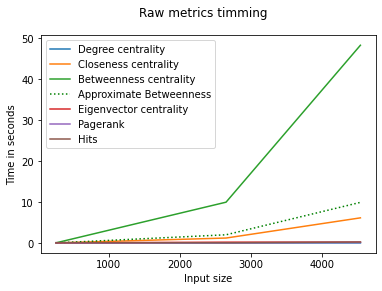

In [12]:
dc_time = [cobol_raw_timings[0],pascal_raw_timings[0],fortran_raw_timings[0]]
cc_time = [cobol_raw_timings[1],pascal_raw_timings[1],fortran_raw_timings[1]]
bc_time = [cobol_raw_timings[2],pascal_raw_timings[2],fortran_raw_timings[2]]
ab_time = [cobol_raw_timings[3],pascal_raw_timings[3],fortran_raw_timings[3]]
ec_time = [cobol_raw_timings[4],pascal_raw_timings[4],fortran_raw_timings[4]]
pr_time = [cobol_raw_timings[5],pascal_raw_timings[5],fortran_raw_timings[5]]
ha_time = [cobol_raw_timings[6],pascal_raw_timings[6],fortran_raw_timings[6]]

plt.plot(number_of_nodes, dc_time, label='Degree centrality')
plt.plot(number_of_nodes, cc_time, label='Closeness centrality')
plt.plot(number_of_nodes, bc_time, label='Betweenness centrality')
plt.plot(number_of_nodes, ab_time, c='green', ls=':', label='Approximate Betweenness')
plt.plot(number_of_nodes, ec_time, label='Eigenvector centrality')
plt.plot(number_of_nodes, pr_time, label='Pagerank')
plt.plot(number_of_nodes, ha_time, label='Hits')

plt.legend()
plt.suptitle('Raw metrics timming')
plt.xlabel('Input size')
plt.ylabel('Time in seconds')
plt.show()

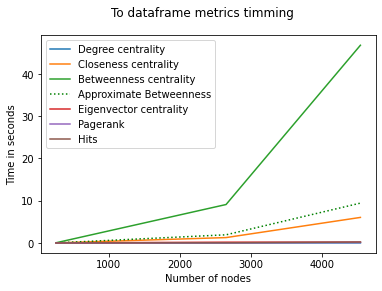

In [13]:
dc_time = [cobol_to_df_timings[0],pascal_to_df_timings[0],fortran_to_df_timings[0]]
cc_time = [cobol_to_df_timings[1],pascal_to_df_timings[1],fortran_to_df_timings[1]]
bc_time = [cobol_to_df_timings[2],pascal_to_df_timings[2],fortran_to_df_timings[2]]
ab_time = [cobol_to_df_timings[3],pascal_to_df_timings[3],fortran_to_df_timings[3]]
ec_time = [cobol_to_df_timings[4],pascal_to_df_timings[4],fortran_to_df_timings[4]]
pr_time = [cobol_to_df_timings[5],pascal_to_df_timings[5],fortran_to_df_timings[5]]
ha_time = [cobol_to_df_timings[6],pascal_to_df_timings[6],fortran_to_df_timings[6]]

plt.plot(number_of_nodes, dc_time, label='Degree centrality')
plt.plot(number_of_nodes, cc_time, label='Closeness centrality')
plt.plot(number_of_nodes, bc_time, label='Betweenness centrality')
plt.plot(number_of_nodes, ab_time, c='green', ls=':', label='Approximate Betweenness')
plt.plot(number_of_nodes, ec_time, label='Eigenvector centrality')
plt.plot(number_of_nodes, pr_time, label='Pagerank')
plt.plot(number_of_nodes, ha_time, label='Hits')

plt.legend()
plt.suptitle('To dataframe metrics timming')
plt.xlabel('Number of nodes')
plt.ylabel('Time in seconds')
plt.show()

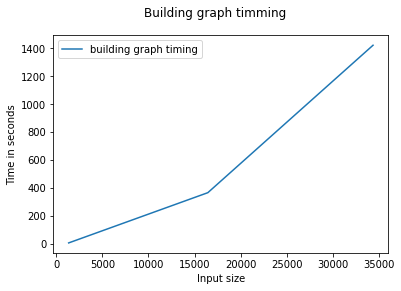

In [14]:
plt.plot(input_size, build_graph_timing, label='building graph timing')

plt.legend()
plt.suptitle('Building graph timming')
plt.xlabel('Input size')
plt.ylabel('Time in seconds')
plt.show()

In [ ]:
# Validation of Betweenness centrality approximation 

true_betweenness = nx.betweenness_centrality(Fortran_G)
true_betweenness = np.fromiter(true_betweenness.values(), dtype=float)

betweenness_approximation = []

betweenness_approximation.append(nx.betweenness_centrality(Fortran_G, k=1))

for i in tqdm(range(50, Fortran_G.number_of_nodes(), 50)):
  aux = nx.betweenness_centrality(Fortran_G, k=i)
  aux = np.fromiter(aux.values(), dtype=float)
  betweenness_approximation.append(aux)



In [ ]:
dist = []

for approximation in betweenness_approximation:
  dist.append(np.linalg.norm(true_betweenness-approximation))

In [ ]:
pivots = [1]
pivots.extend(list(range(50, Fortran_G.number_of_nodes(), 50)))


plt.plot(pivots, dist)

plt.suptitle('Eucledean distance from true betweenness centrality to approximation')
plt.xlabel('Number of pivots')
plt.ylabel('Eucledean distance')
plt.show()